## Example 2: Performing a spectral fit using artificial data in the Uv/Vis
Part of ESE 156 Remote Sensing Class; Christian Frankenberg
___
The purpose of this exercise is to go one step further, understanding how we can phrase observed log(radiances) as a linear system of equations (in Matrix form), using absorption optical depths by a set of absorbers and a simple polynomial for surface properties (we can assume we are having an artificial light shining back and forth a chamber).

Most of the absorption cross sections used here are obtained via

http://www.iup.uni-bremen.de/gruppen/molspec/databases/index.html

http://spectrolab.aeronomie.be/o2.htm

In the UV/Vis, a lot of the cross sections are derived in the lab and not just theoretical predictions (kind of a different inverse problem where the concentration in the cell as well as the cell-length, pressure and temperature is known, allowing them to derive the absorption cross section $\sigma$.

In the most basic sense, we are making use of Beer's law here:
$$I(\lambda) = I_0(\lambda)\cdot \exp\left(-\sum_{i=1}^N \sigma_i \int_0^l n_i(z)dz\right)$$

The basic question here is how can we define a Matrix based linear forward model if we want to retrieve the column density ($\int_0^l n_i(z)dz$, in $molec/cm^2$) for each trace gas $i$, with respective cross section $\sigma_i$ (in $cm^2$)?

In [5]:
## Make sure plots are create inline
%matplotlib inline
# Loading some style files for this class
from RSE_style import *
from urllib.request import urlopen

In [3]:
figsize(11.,11./1.618)
urllib.

____
Load some absorption cross sections for different gases ($\sigma_i$) (all have a different format, I just masked the comments with # here)

In [6]:
# Define file names (directly on the ftp server using the urllib2 module)
file_no2_1 = urlopen("ftp://fluo.gps.caltech.edu/XYZT_ESE156/Data/xSections/No2_293h.dat")
file_no2_2 = urlopen("ftp://fluo.gps.caltech.edu/XYZT_ESE156/Data/xSections/No2_260h.dat")
file_BrO = urlopen("ftp://fluo.gps.caltech.edu/XYZT_ESE156/Data/xSections/BrO_Cross_298K_Static_FTS_4cm.dat")
file_SO2 = urlopen("ftp://fluo.gps.caltech.edu/XYZT_ESE156/Data/xSections/so2_16.nm.dat")
file_O3 = urlopen("ftp://fluo.gps.caltech.edu/XYZT_ESE156/Data/xSections/ozone_crossSection.dat")
file_Glyoxal = urlopen("ftp://fluo.gps.caltech.edu/XYZT_ESE156/Data/xSections/glyoxal_cross_section.dat")

no2_293K = np.loadtxt(file_no2_1)
no2_260K = np.loadtxt(file_no2_2)
bro = np.loadtxt(file_BrO)
so2 = np.loadtxt(file_SO2)
o3 = np.loadtxt(file_O3)
glyo = np.loadtxt(file_Glyoxal)

### Plot cross sections

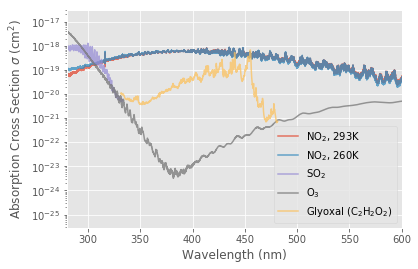

In [7]:
plt.semilogy(no2_293K[:,0], no2_293K[:,2],label='NO$_2$, 293K', alpha=0.75)
plt.semilogy(no2_260K[:,0], no2_260K[:,2],label='NO$_2$, 260K', alpha=0.75)
plt.semilogy(so2[:,0], so2[:,1],label='SO$_2$', alpha=0.75)
plt.semilogy(o3[:,0], o3[:,1],label='O$_3$', alpha=0.75)
plt.semilogy(glyo[:,1], glyo[:,3],label='Glyoxal (C$_2$H$_2$O$_2$)', alpha=0.75)

plt.xlim((280,600))
plt.legend(loc=0)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorption Cross Section $\sigma$ (cm$^2$)')

___ 
Let us define a common wavelength grid at which the detector should take data and then interpolate the cross sections to that grid

In [8]:
wl = np.arange(405,465,0.1)

In [9]:
no2_cs_1 = np.interp(wl,no2_293K[::-1,0], no2_293K[::-1,2])
no2_cs_2 = np.interp(wl,no2_260K[::-1,0], no2_260K[::-1,2])
o3_cs = np.interp(wl,o3[:,0], o3[:,1])
glyo_cs = np.interp(wl,glyo[:,1], glyo[:,3])

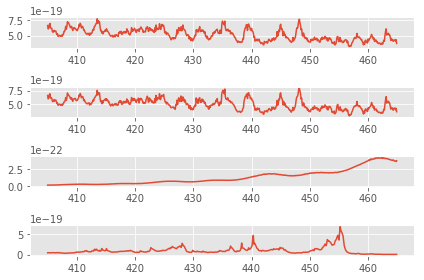

In [10]:
plt.subplot(411)
plt.plot(wl,no2_cs_1)
plt.subplot(412)
plt.plot(wl,no2_cs_2)
plt.subplot(413)
plt.plot(wl,o3_cs)
plt.subplot(414)
plt.plot(wl,glyo_cs)
plt.tight_layout()

### Create a pseudo-measurement (with random noise)
Let's create some pseudo measurement using 3 species only, Ozone, NO2 and Glyoxal, for which we assume a vertical column density of 1e19, 1.5e16 and 1e15 molec/cm$^2$, respectively (somewhat realistic numbers for the Earth's atmosphere)

In [11]:
# Create a pseudo-measurement
# First a polynomial term
p = np.poly1d([0.00003, -0.002, 2])

# Solar Zenith Angle
sza = 40

# Vertical column densities
vcd_no2 = 1.5e16
vcd_o3 = 1e19
vcd_glyo = 1.0e15

# Create some fake measurement with specific vertical columns. Convert Vertical column into slant column:
AMF = 1+1./np.cos(sza/180.*np.pi)

# Lambert Beer law (just with a prefactor polynomial)
I = np.exp(-AMF*1e19*o3_cs)*np.exp(-AMF*1.5e16*no2_cs_1)*np.exp(-AMF*1.e15*glyo_cs)*p(wl-440)

# Give it roughly an SNR of 1000 (pretty high!)
SNR = 1000
noise = np.mean(I)/SNR
I = I+np.random.randn(len(I))*noise

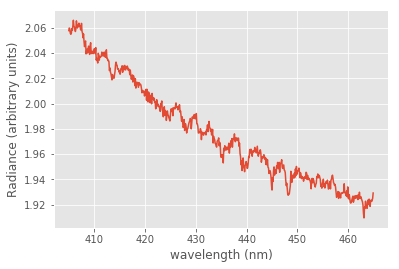

In [12]:
plt.plot(wl,I)
plt.xlabel('wavelength (nm)')
plt.ylabel('Radiance (arbitrary units)')

--- 
### So, how do fit the vertical column densities of each gas? Can you set this up?

In [13]:
# Just as an example to isolate the higher frequency spectrum here (try to fit all in one though!).
p2 = np.polyfit(wl,I,3)
pf = np.poly1d(p2)

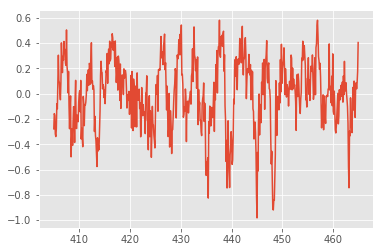

In [14]:
plt.plot(wl,100*(np.log(I)-np.log(pf(wl))))

______________________
<font color=red>**Question:**</font> Write down the matrix equation for the linearized system. Phrase the problem again as a linear system $Ax=b$

### Simple solution:

[  1.81072163e+19   3.47233947e+16   2.09397056e+15   2.28646893e+00
  -2.72201016e-03  -9.96402840e-06   1.79939290e-08]


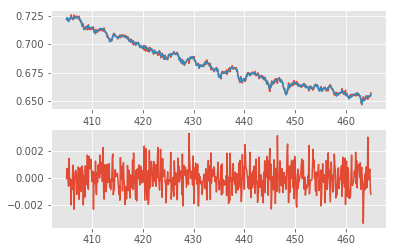

In [15]:
m = len(I)
K = np.array([-o3_cs,-no2_cs_1,-glyo_cs, np.ones(m), wl, wl**2, wl**3]).T
K.shape
sv = np.linalg.inv(K.T.dot(K)).dot(K.T).dot(np.log(I))
print(sv)
plt.subplot(211)
plt.plot(wl, np.log(I),wl, K.dot(sv) )
plt.subplot(212)
plt.plot(wl, K.dot(sv)-np.log(I) )

____ 
Let's make a pretty plot of all the fit components now

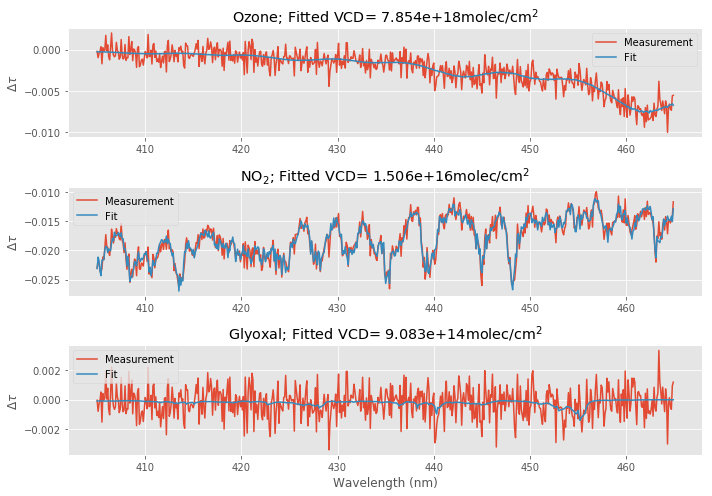

In [16]:

figsize(10,7)
leg = ['Ozone','NO$_2$','Glyoxal']

# Just use the Trace gases here, not the polynomial coefficients
for i in range(3):
    sv_copy = sv.copy()
    sv_copy[i]=0
    
    plt.subplot(3,1,i+1)
    plt.title(leg[i]+'; Fitted VCD='+ "%10.3e"% (sv[i]/AMF)+ 'molec/cm$^2$')
    plt.plot(wl, np.log(I)-K.dot(sv_copy), wl, K.dot(sv-sv_copy) )
    plt.ylabel(r'$\Delta \tau$')
    plt.legend(['Measurement','Fit'], loc=0)
plt.xlabel('Wavelength (nm)')
plt.tight_layout()


### Things we ignored here for now:

<li> A true solar spectrum with absorptions (we kind of used a spectrally flat sun)
<li> Ring effect that causes a pseudo-absorber due to rotational Raman scattering
<li> An instrument function (apart from a sampling we used)
<li> Changes in spectral characteristics (shift and squeeze of the wavelength grid)

______________________
<font color=red>**Questions:**</font> 

Can you rewrite the system as weighted least squares and compute the errors for each trace gas as a function of SNR (say from 50-5000)? 

Can you add the NO$_2$ cross section for both temperatures in the linear system? What happens if you fit both at the same time (you can use an ensemble of fits using different noise realizations)? Can you explain this behavior with the posterior covariance matrix? What might be the reason for this behavior (mathematically speaking) and how could you stabilize the fit?

### Another complication for stronger absorbers:
So far, we have basically assumed that the Airmass factor AMF is independent of wavelength, allowing us to separate the retrievals of Slant Column Densities from the actual radiative transfer calculations that would allow us to infer Vertical columns from Slant columns (in the easiest case, just from geometric considerations as explained above).

Once strong absorptions take place (or scattering cross sections change rapidly), the AMF can depend on wavelength. Ozone in the UV is a prominent example as its cross section varies by 1-2 orders of magnitude within just 30-40nm. In the more strongly absorbing wavelenths, most of the measured photons will come from atmospheric scattering while the average penetration depth increases with decreasing cross section. Also, in the UV Rayleigh scattering is very strong and surface scattering contribution less so than in the Vis and near-infrared. 

For these kind of retrievals, some of our assumptions break down and we would need to really couple radiative transfer calculations to the retrieval (which might enable us to also retrieve some vertical profile information, more on that later).

Text(0.5,1,'SO$_2$ cross section overlap with Ozone in the UV')

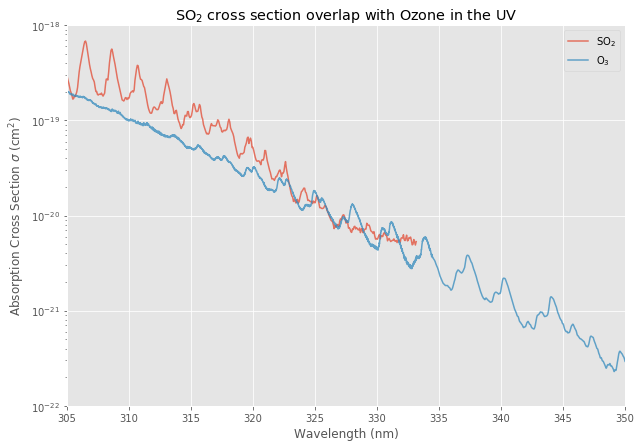

In [14]:
plt.semilogy(so2[:,0], so2[:,1],label='SO$_2$', alpha=0.75)
plt.semilogy(o3[:,0], o3[:,1],label='O$_3$', alpha=0.75)

plt.xlim((305,350))
plt.ylim((1e-22,1e-18))
plt.legend(loc=0)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorption Cross Section $\sigma$ (cm$^2$)')
plt.title('SO$_2$ cross section overlap with Ozone in the UV')

### Ozone:
Typical Ozone columns are around 300Dobosn units (1DU = 2.69e16)


Text(0.5,1,'O$_3$ atmospheric transmission (vertical only)')

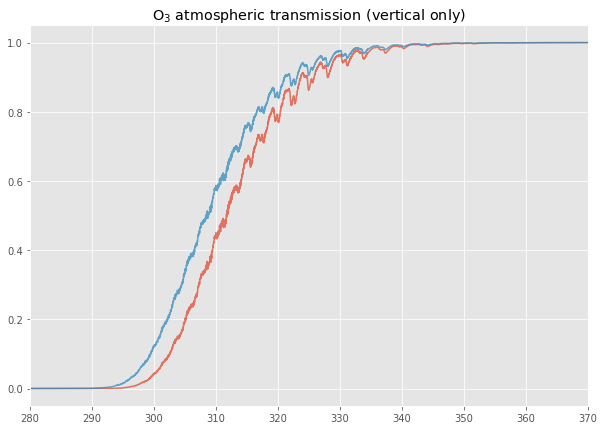

In [15]:
plt.plot(o3[:,0], np.exp(-300*2.69e16*o3[:,1]),label='O$_3$, 300DU', alpha=0.75)
plt.plot(o3[:,0], np.exp(-200*2.69e16*o3[:,1]),label='O$_3$, 200DU', alpha=0.75)
plt.xlim((280,370))
plt.title('O$_3$ atmospheric transmission (vertical only)')